<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Базовые-модели" data-toc-modified-id="Базовые-модели-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Базовые модели</a></span></li></ul></li><li><span><a href="#Bert" data-toc-modified-id="Bert-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bert</a></span><ul class="toc-item"><li><span><a href="#Model-config" data-toc-modified-id="Model-config-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Model config</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span><ul class="toc-item"><li><span><a href="#Ниже-изображено-изменение-метрики-f1-на-каждой-эпохе-(всего-4)-в-двух-экспериментах.-Хорошо-видно-как-первый-эксперимент-начал-переобучаться-почти-сразу." data-toc-modified-id="Ниже-изображено-изменение-метрики-f1-на-каждой-эпохе-(всего-4)-в-двух-экспериментах.-Хорошо-видно-как-первый-эксперимент-начал-переобучаться-почти-сразу.-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Ниже изображено изменение метрики f1 на каждой эпохе (всего 4) в двух экспериментах. Хорошо видно как первый эксперимент начал переобучаться почти сразу.</a></span></li></ul></li></ul></div>

# Проект для «Викишоп» c  BERT



Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
# !pip install torch
# !pip install torchmetrics

In [2]:
#!pip install -r requirements.txt >> Null

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
import re 


import os
from tqdm.notebook import tqdm

# import torch
# from transformers import BertTokenizer, BertModel
# import transformers

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

SEED = 41
MODEL_NAME = 'bert-base-uncased'


[nltk_data] Downloading package stopwords to /Users/ac1d/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def evaluate_and_report(report_df:pd.DataFrame, 
                        model, X, y, 
                        model_name, scoring='f1', 
                        predict_proba=False, 
                        thresh=0.3):
    '''
    Function to evaluate model and make report Dataframe
    '''
    
    report = pd.DataFrame()
    report.index = [model_name]
    if predict_proba:
        predicted = (model.predict_proba(X)[:,1] >= thresh).astype(int)
        report['f1'] = f1_score(y, predicted)
                       
                       
    else:
        predicted = model.predict(X)
        report['f1'] = f1_score(y, predicted)
    
    
    
    report.loc[:,'precision_0'] = precision_score(
        y, predicted, pos_label=0)
    report.loc[:,'precision_1'] = precision_score(
        y, predicted, pos_label=1)
    report.loc[:,'recall_0'] = recall_score(
        y, predicted, pos_label=0)
    report.loc[:,'recall_1'] = recall_score(
        y, predicted, pos_label=1)
    
    
    report_df = pd.concat([report_df, report])
    return report_df

## Подготовка

In [3]:
df_path = '../datasets/toxic_comments.csv'
df = pd.read_csv(df_path)

In [4]:
df

,text,toxic,lemmatize
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m s...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,And for the second time of asking when ...
159567,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That is a ...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm theres no actual article for pr...
159569,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...


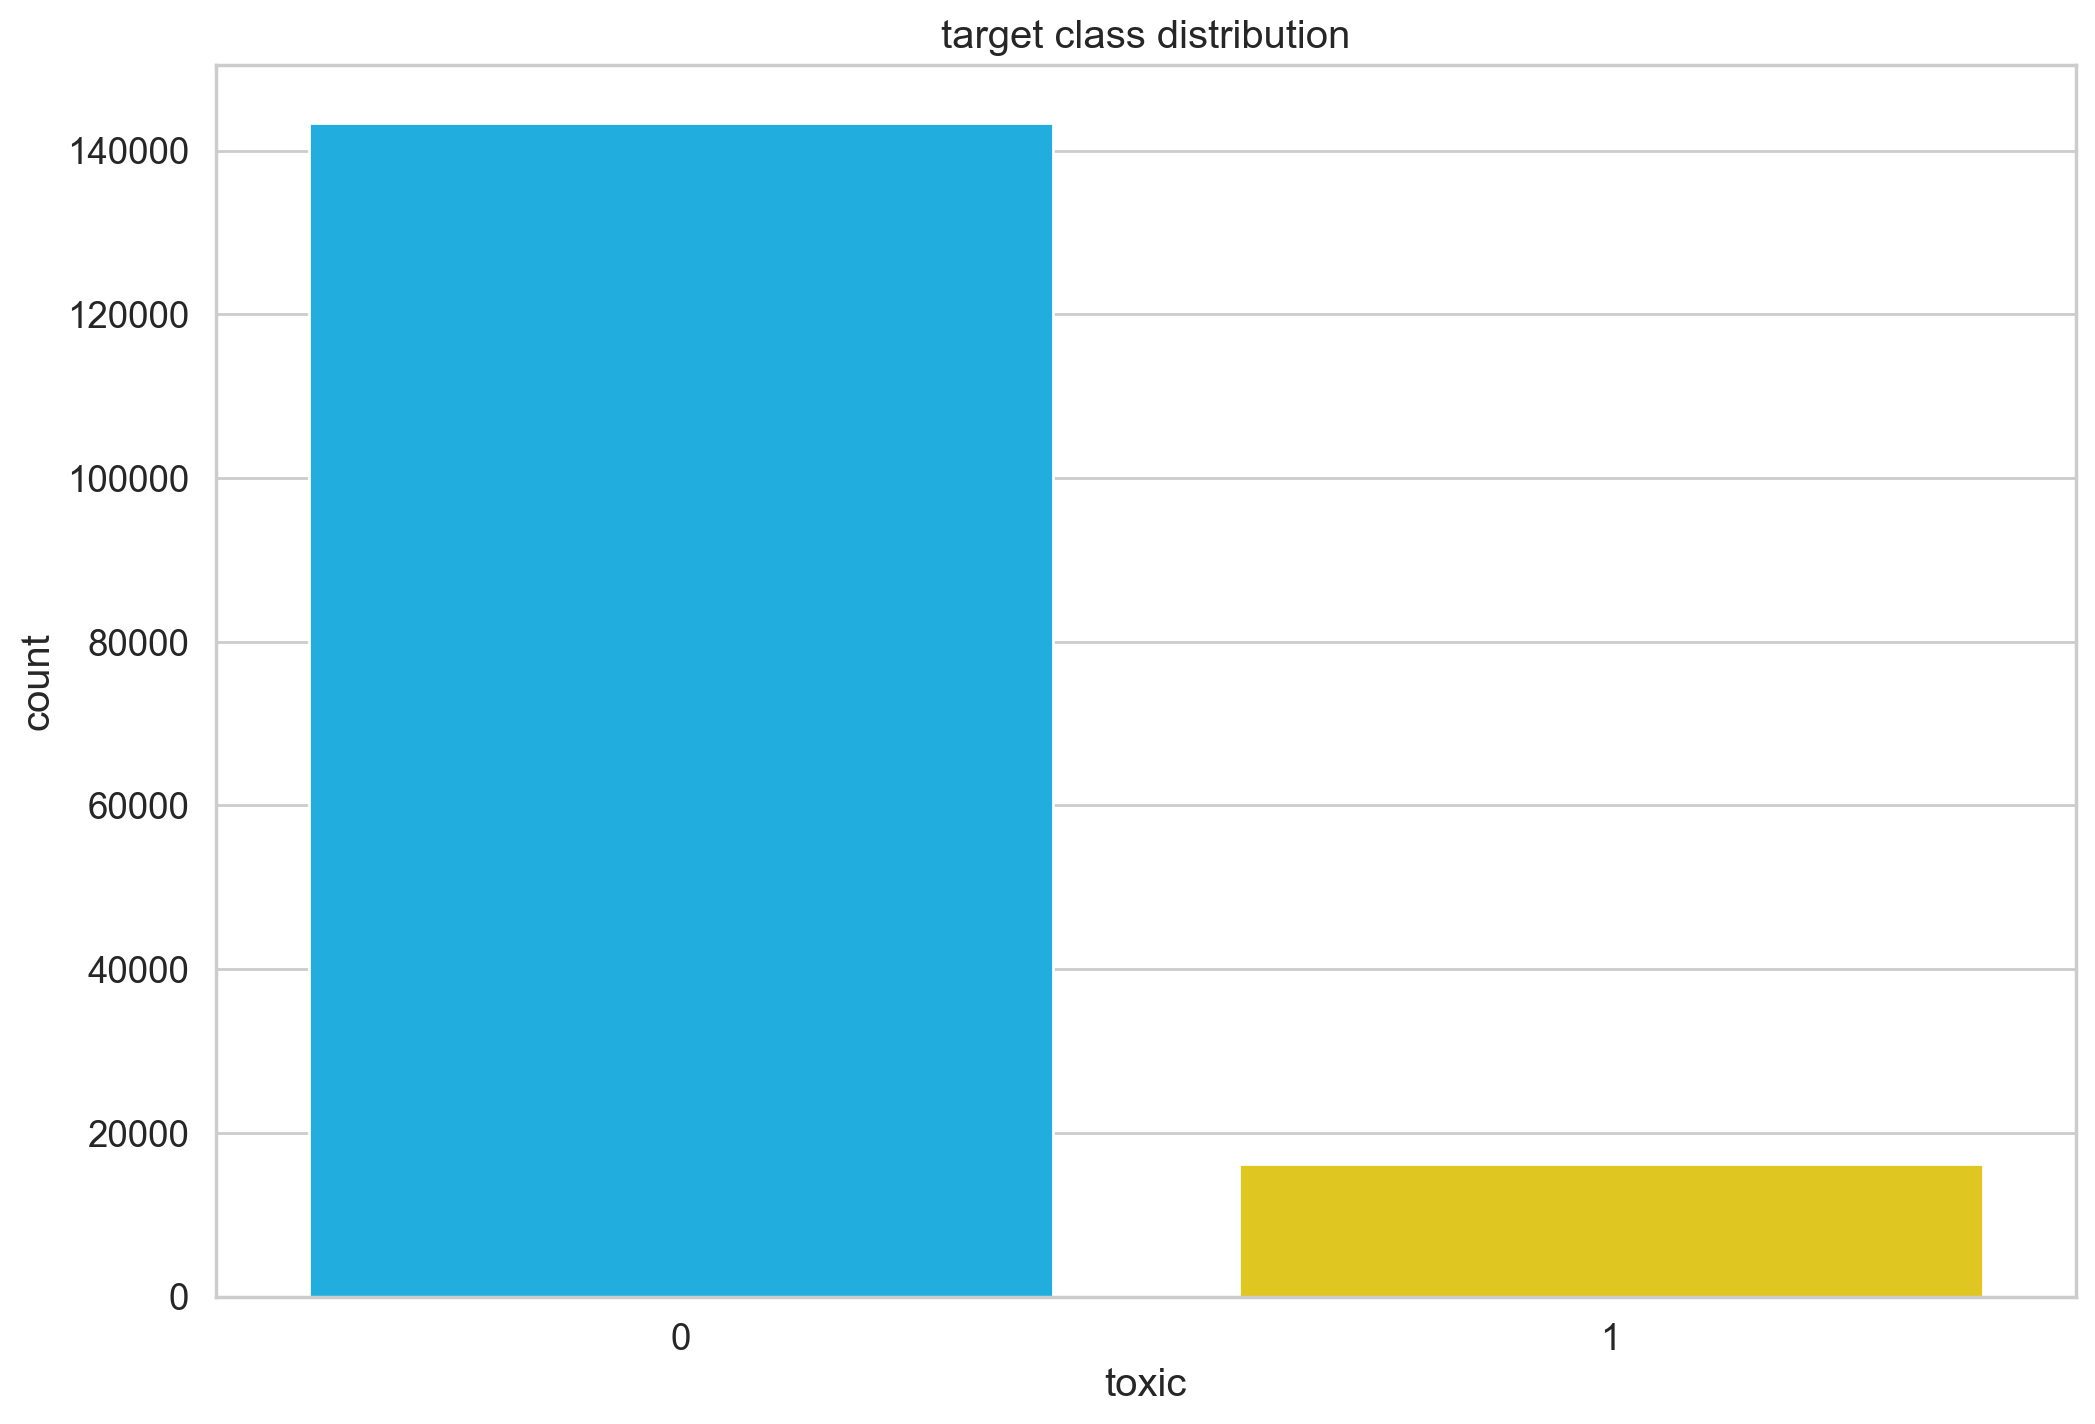

In [5]:
sns.countplot(data=df, x='toxic')
plt.title('target class distribution');

In [6]:
m = WordNetLemmatizer()
cleared = []

for i in tqdm(range(df.shape[0])):
    text = re.sub(r'[^a-zA-Z]', ' ', df['text'][i])
    text = m.lemmatize(text)
    text = ''.join(text)
    cleared.append(text)
df['lemmatize'] = cleared
df['lemmatize'][0]

  0%|          | 0/159571 [00:00<?, ?it/s]

'Explanation Why the edits made under my username Hardcore Metallica Fan were reverted  They weren t vandalisms  just closure on some GAs after I voted at New York Dolls FAC  And please don t remove the template from the talk page since I m retired now             '

In [7]:
df

,text,toxic,lemmatize
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m s...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,And for the second time of asking when ...
159567,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That is a ...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm theres no actual article for pr...
159569,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...


In [8]:
stop_words = list(set(stopwords.words('russian')))
tfidf_vect = TfidfVectorizer(stop_words=stop_words)
    
transformed = tfidf_vect.fit_transform(df['lemmatize'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(transformed, df.toxic,
                                                   test_size=.3)

## Обучение

### Базовые модели

In [12]:
# Baseline - logreg
logreg_model = LogisticRegression()

logreg_model.fit(X_train, y_train)

report_df = pd.DataFrame()
report_df = evaluate_and_report(report_df, logreg_model, X_test, y_test, 'logreg')
report_df

/opt/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,f1,precision_0,precision_1,recall_0,recall_1
logreg,0.730526,0.95641,0.93038,0.994882,0.60135


In [13]:
# Random forest
rf_model = RandomForestClassifier(random_state=SEED, 
                                  n_estimators=50,
                                  n_jobs=-1,
                                 verbose=1)

rf_model.fit(X_train, y_train)

report_df = evaluate_and_report(report_df, rf_model, X_test, y_test, 'random_forest')
report_df

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   56.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


,f1,precision_0,precision_1,recall_0,recall_1
logreg,0.730526,0.956410,0.930380,0.994882,0.601350
random_forest,0.572621,0.936701,0.966472,0.998395,0.406832


In [14]:
# lightGBM

lgb_model = LGBMClassifier(random_state=SEED)

lgb_model.fit(X_train, y_train)

LGBMClassifier(random_state=41)

In [15]:
report_df = evaluate_and_report(report_df, lgb_model, X_test, y_test, 'lightgbm')
report_df

,f1,precision_0,precision_1,recall_0,recall_1
logreg,0.730526,0.956410,0.930380,0.994882,0.601350
random_forest,0.572621,0.936701,0.966472,0.998395,0.406832
lightgbm,0.750391,0.960178,0.910923,0.992904,0.637963


In [17]:
report_df = evaluate_and_report(report_df, lgb_model, X_test, y_test, 'lightgbm_thresh_0.3', predict_proba=True)
report_df

,f1,precision_0,precision_1,recall_0,recall_1
logreg,0.730526,0.956410,0.930380,0.994882,0.601350
random_forest,0.572621,0.936701,0.966472,0.998395,0.406832
lightgbm,0.750391,0.960178,0.910923,0.992904,0.637963
lightgbm_thresh_0.3,0.778095,0.969209,0.839451,0.984226,0.725097
lightgbm_thresh_0.3,0.778095,0.969209,0.839451,0.984226,0.725097


## Bert

In [10]:
from pathlib import Path

# check where is notebook running 
try:
    import google.colab
    COLAB = True
except:
    COLAB = False
    
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    # ROOT = Path('drive/MyDrive/Colab_Notebooks/')
    %cd drive/MyDrive/Colab_Notebooks/toxic_comment_detection/

    !pip install -r requirements.txt

df_path = '../datasets/toxic_comments.csv'

# check files:
print(f">>> df path exists: {Path(df_path).exists()}")
print(f">>> requirements exists: {Path('requirements.txt').exists()}")



>>> df path exists: True
>>> requirements exists: True


In [11]:
# # WandB – Import the wandb library
import wandb

from transformers import AutoTokenizer, BertModel, BertTokenizer

from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertModel
from func import *
import pandas as pd
import random
import platform
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, random_split


    
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# df_path = '../datasets/toxic_comments.csv'

### Model config

In [12]:
MODEL_NAME = 'bert-base-uncased'  # parameter for download pretrained model and tokenizer
MAX_LENGTH = 200  # length to truncate

FRAQ = 1 # perc of data to use. needed for debug mode
EPOCHS = 4
BATCH_SIZE = 16
LEARNING_RATE = 3e-6
LOG_INTERVAL = 100

# wandb
USE_WANDB = True
# os.environ["WANDB_MODE"]="offline"

PROJECT_NAME = 'toxic_comment_detection'
RUN_NAME = 'dropout05 adamW full dataset'
# Number of training epochs. The BERT authors
# recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
DEVICE = choose_device(platform.system())

SAVE_PATH = 'saved_models'
TOKENIZED_PATH = 'encoded_dict.pkl'

In [13]:
# original paper text:
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [14]:
df = pd.read_csv(df_path)

In [15]:
df

,text,toxic,lemmatize
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m s...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,And for the second time of asking when ...
159567,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That is a ...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm theres no actual article for pr...
159569,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...


In [24]:
# Lets see to the mean length of the sentences. 
# Its important to set truncation in tokenizer
df['lemmatize'].apply(lambda x: len(x.split())).describe()

count    159571.000000
mean         68.138221
std         100.941396
min           0.000000
25%          17.000000
50%          36.000000
75%          76.000000
max        1403.000000
Name: lemmatize, dtype: float64

In [16]:


# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# tokens_dict = make_tokens(tokenizer, df, TOKENIZED_PATH, MAX_LENGTH, fraq=FRAQ)

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
tokens_dict = make_tokens(tokenizer,
                          df,
                          TOKENIZED_PATH,
                          MAX_LENGTH,
                          fraq=FRAQ,
#                           df_column='lemmatize',
                         force=True
                         )

making tokens:   0%|          | 0/159571 [00:00<?, ?it/s]

>>> Tokens saved successful to encoded_dict.pkl


In [17]:
# Combine the training inputs into a TensorDataset.
# dataset = TensorDataset(tokens_dict['input_ids'], tokens_dict['attention_masks'], tokens_dict['labels'])
dataset = TensorDataset(tokens_dict['input_ids'],
                        tokens_dict['attention_masks'],
                        tokens_dict['token_type_ids'],
                        tokens_dict['labels'])

train_size = int(0.80 * len(dataset))
val_size = int(len(dataset) - train_size) // 2
test_size = int(len(dataset) - train_size - val_size)

# # Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset  = random_split(dataset, [train_size, val_size, test_size])

print(f'{train_size:>5,} train samples')
print(f'{val_size:>5,} validation samples')
print(f'{test_size:>5,} test samples')

127,656 train samples
15,957 validation samples
15,958 test samples


In [18]:
# from torch.utils.data import WeightedRandomSampler
# # Compute class weights for weighted sampler
# target = [t[2].item() for t in train_dataset]
# class_sample_count = np.array(
#     [len(np.where(target == t)[0]) for t in np.unique(target)])
# weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])

# samples_weight = torch.from_numpy(samples_weight)
# samples_weight = samples_weight.double()
# sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
# batch_size = 32 

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            # sampler=sampler,
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )
test_dataloader = DataLoader(
    test_dataset,
    sampler = SequentialSampler(test_dataset),
    batch_size = BATCH_SIZE
)

In [19]:
# model = BertModel.from_pretrained('bert-base-uncased')
#
# tmp_tokenized = tokenizer.encode_plus(df.text[0],
#                                       return_attention_mask=True,
#                                      return_tensors='pt',
#                                      return_token_type_ids=True,
#                                      )

In [20]:
# Custom model from 
# 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.5)
        self.l3 = torch.nn.Linear(768, 2)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1 = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [12]:
# model = BertForSequenceClassification.from_pretrained(
#     MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
# )

# model.to(DEVICE)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)


print(f">>> Training on: {DEVICE}")


train_dict = train_loop(model, train_dataloader, validation_dataloader, 
           EPOCHS, 
            optimizer,
            scheduler,
           SAVE_PATH, 
           device=DEVICE, 
           use_wandb=USE_WANDB,
           proj_name=PROJECT_NAME,
           run_name=RUN_NAME,
           log_interval=LOG_INTERVAL,
           model_name=MODEL_NAME
          )

>>> Training on: mps


wandb: Network error (ConnectionError), entering retry loop.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Problem at: /Users/ac1d/PycharmProjects/practicum/13_NLP/func.py 257 train_loop


KeyboardInterrupt: 

In [21]:
last_model = list(Path(SAVE_PATH).glob('*best.pth'))[-1]
print(last_model)
model.load_state_dict(torch.load(last_model))

saved_models/bert-base-uncased_20230301_16_11_1_f1_8512best.pth


<All keys matched successfully>

In [22]:
_, val_true, val_preds = eval_epoch(validation_dataloader, model, DEVICE)
_, test_true, test_preds = eval_epoch(test_dataloader, model, DEVICE)
print(f"Validation f1: {f1_score(val_true, val_preds)}")
print(f"Test f1: {f1_score(test_true, test_preds)}")

valid:   0%|          | 0/998 [00:00<?, ?it/s]

valid:   0%|          | 0/998 [00:00<?, ?it/s]

Validation f1: 0.851275668948351
Test f1: 0.849628712871287


In [32]:
bert_report = pd.DataFrame(index=['Bert'], data={'f1':f1_score(test_true, test_preds),
                            'precision_0': precision_score(test_true, test_preds, pos_label=0),
                           'precision_1': precision_score(test_true, test_preds, pos_label=1),
                           'recall_0':recall_score(test_true, test_preds, pos_label=0),
                           'recall_1':recall_score(test_true, test_preds, pos_label=1)})

In [33]:
report_df = pd.concat([bert_report, report_df])
report_df.sort_values(by='f1', ascending=False)

,f1,precision_0,precision_1,recall_0,recall_1
Bert,0.841144,0.980808,0.848373,0.982728,0.834037
lightgbm_thresh_0.3,0.778095,0.969209,0.839451,0.984226,0.725097
lightgbm_thresh_0.3,0.778095,0.969209,0.839451,0.984226,0.725097
lightgbm,0.750391,0.960178,0.910923,0.992904,0.637963
logreg,0.730526,0.956410,0.930380,0.994882,0.601350
random_forest,0.572621,0.936701,0.966472,0.998395,0.406832


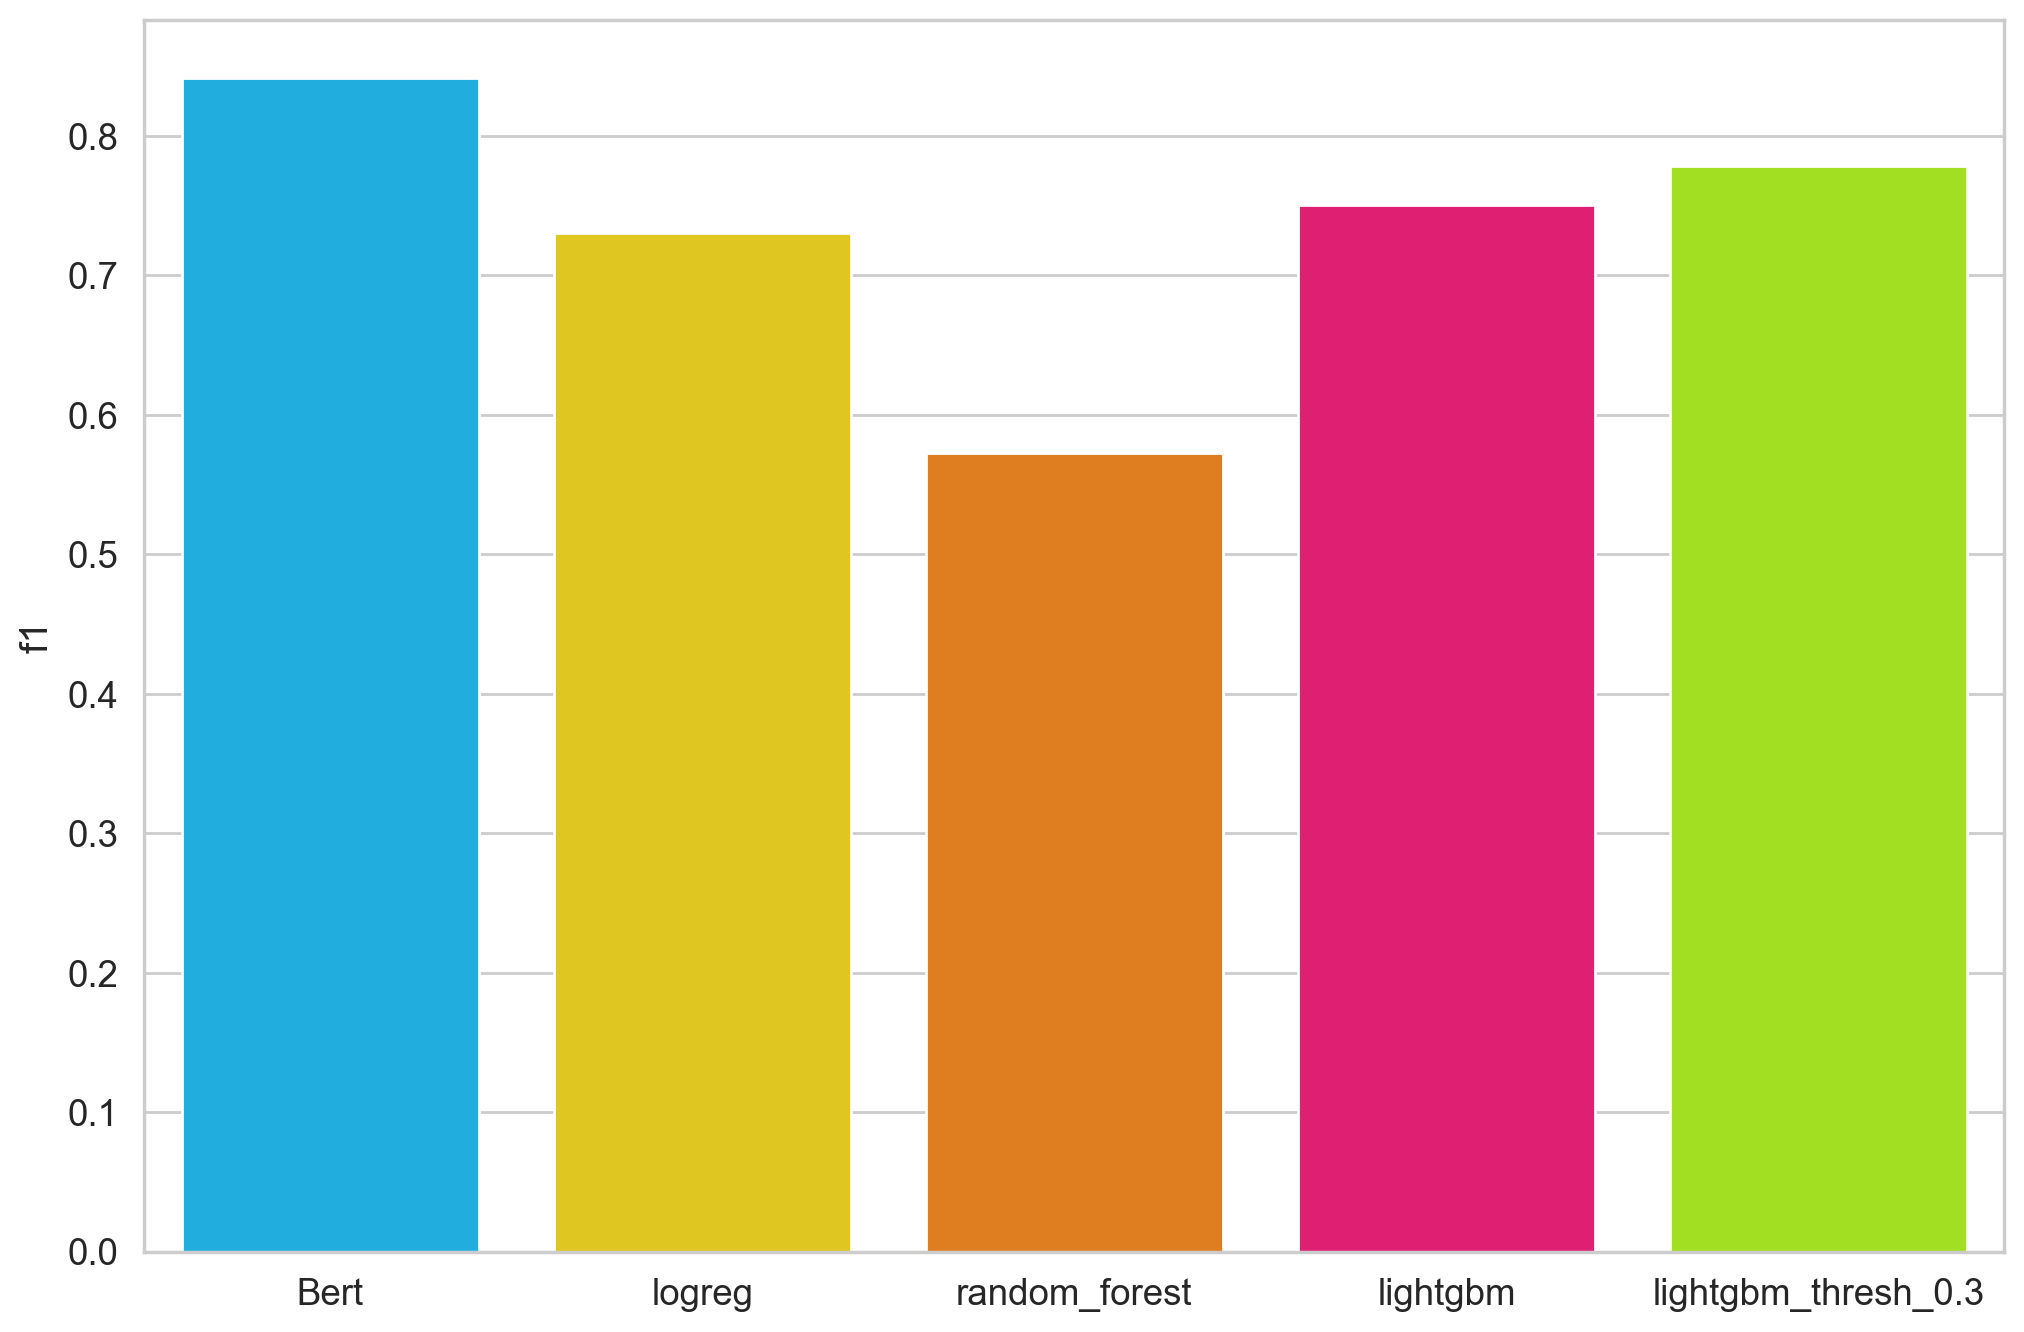

In [34]:
sns.barplot(y=report_df['f1'], x=report_df.index);

## Выводы

- Наш датасет имеет дисбаланс классов, токсичных комментариев значительно меньше обычных.
- хорошо видно, что именно полнота класса 1 имеет низкие значения, что вносит свой вклад в низкую оценку f1.
- Для нашей задачи не страшно, если мы неправильно пометим нетоксичные комментарии в небольших количествах случаев (False Positive)
поэтому для борьбы с дисбалансом классов принято решение изменить порог логистической регрессии с 0.5 до 0.3. 
- Результат по прохождению необходимого порога метрики F1 достигнут. 

**Bert**

- Ожидаемо именно Bert дает наилучший результат. 
- на тестовой выборке удалось достичь результат f1 = 0.849
- Было запущено несколько экспериментов:
    - В первом, использовалась модель Bert из huggingface, с указанием количества классов ( в нашем случае два). 
    - Во втором эксперименте было добавлено два слоя: Dropout (для борьбы с переобучением) и последний линейный слой, с указанием кол-ва классов. 
    - В обоих случаях модель довольно сильно переобучалась, наилучший результат по f1 достигался ко второй эпохе, однако в первом случае, без использования Dropout слоя (регуляризации), результат был несколько хуже.
    
- Также в ходе экспериментов, для борьбы с дисбалансом классов была попытка использовать WeightedRandomSampler, однако такой подход сработал хуже RandomSampler. 
- При необходимости, можно и дальше эксперементировать с Bert и, возможно, достичь лучшего качества, однако на данном этапе мы с запасом первысили необходимый порог f1. 



### Ниже изображено изменение метрики f1 на каждой эпохе (всего 4) в двух экспериментах. Хорошо видно как первый эксперимент начал переобучаться почти сразу. 

![Alt](eval_f1.png)